

# **Proyecto C: Optimización en la Planificación de Rutas Nacionales y Estrategia de Recarga para Logistico**

## Caso 2


El objetivo del caso 2 es extender el modelo anterior para incluir decisiones de recarga.

- Tomar en cuenta los diferentes precios de combustible en estaciones a lo largo del recorrido.
- Asegurar que ningún vehículo se quede sin combustible en ninguna parte de la ruta.
- Este caso permite probar estrategias como recarga completa vs. recarga mínima necesaria

## Utils

In [1]:
%%capture
%pip install networkx matplotlib
%pip install haversine folium
%pip install seaborn
%pip install amplpy pyomo -q
%python -m amplpy.modules install coin highs scip gcg -q


In [2]:

from pyomo.environ import (
    ConcreteModel, RangeSet, Var, ConstraintList, Objective,
    Binary, Integers, NonNegativeReals, minimize
)
from pyomo.opt import SolverFactory

In [12]:
from haversine import haversine
import matplotlib.pyplot as plt
from amplpy import modules
from pyomo.environ import *
import pandas as pd
import folium
import requests
import itertools
from geopy.distance import geodesic

In [5]:
import requests
from haversine import haversine
from itertools import product


# ——————————————————————————————————————————————————————————————————
# 1) Funciones para OSRM y coordenadas
# ——————————————————————————————————————————————————————————————————
def get_coordinates(nodo, puertos, municipios, estaciones):
    if nodo in puertos:
        return puertos[nodo]['lat'], puertos[nodo]['lon']
    if nodo in municipios:
        return municipios[nodo]['lat'], municipios[nodo]['lon']
    if nodo in estaciones:
        return estaciones[nodo]['lat'], estaciones[nodo]['lon']
    raise KeyError(f"Nodo {nodo} no encontrado.")

def build_osrm_url(lat1, lon1, lat2, lon2):
    base = "http://router.project-osrm.org/route/v1/driving/"
    return f"{base}{lon1},{lat1};{lon2},{lat2}"

def get_route_info(lat1, lon1, lat2, lon2):
    url = build_osrm_url(lat1, lon1, lat2, lon2)
    try:
        resp = requests.get(url, params={'overview':'full','geometries':'geojson'})
        resp.raise_for_status()
        js = resp.json()
        route = js['routes'][0]
        dist_km = route['distance'] / 1000.0
        poly = [[lat, lon] for lon, lat in route['geometry']['coordinates']]
        return dist_km, poly
    except Exception:
        fallback = geodesic((lat1, lon1),(lat2, lon2)).kilometers
        return fallback, [[lat1, lon1], [lat2, lon2]]

def calcular_distancias_y_geometrias(puertos, municipios, estaciones, get_route_fn):
    nodos = list(puertos) + list(municipios) + list(estaciones)
    distancias, geometries = {}, {}
    for i, j in product(nodos, repeat=2):
        if i == j or (i in puertos and j in puertos):
            continue
        lat_i, lon_i = get_coordinates(i, puertos, municipios, estaciones)
        lat_j, lon_j = get_coordinates(j, puertos, municipios, estaciones)
        d, poly = get_route_fn(lat_i, lon_i, lat_j, lon_j)
        distancias[(i, j)] = d
        geometries[(i, j)] = poly
    return distancias, geometries


In [16]:
from itertools import product
import folium

def visualizar_rutas_folium(model, puertos, municipios, estaciones,
                             colores_vehiculos=None, nombre_archivo="ruta_caso2.html"):
    if colores_vehiculos is None:
        colores_vehiculos = {}

    # Centro del mapa
    all_coords = (
        [(puertos[p]['lat'], puertos[p]['lon']) for p in puertos] +
        [(municipios[c]['lat'], municipios[c]['lon']) for c in municipios] +
        [(estaciones[e]['lat'], estaciones[e]['lon']) for e in estaciones]
    )
    mean_lat = sum(lat for lat,_ in all_coords) / len(all_coords)
    mean_lon = sum(lon for _,lon in all_coords) / len(all_coords)
    m = folium.Map(location=[mean_lat, mean_lon], zoom_start=6)

    # Marcadores
    for p in puertos:
        folium.Marker(
            [puertos[p]['lat'], puertos[p]['lon']],
            popup=f"Puerto {p}",
            icon=folium.Icon(color='green', icon='ship', prefix='fa')
        ).add_to(m)
    for c in municipios:
        folium.Marker(
            [municipios[c]['lat'], municipios[c]['lon']],
            popup=f"Municipio {c}",
            icon=folium.Icon(color='blue', icon='user', prefix='fa')
        ).add_to(m)
    for e in estaciones:
        folium.Marker(
            [estaciones[e]['lat'], estaciones[e]['lon']],
            popup=f"Estación {e} (Costo {estaciones[e]['fuel_cost']})",
            icon=folium.Icon(color='red', icon='tint', prefix='fa')
        ).add_to(m)

    # Rutas como líneas rectas (sin geometrías OSRM)
    for k in model.V:
        vid = f"CAM{str(k).zfill(3)}"
        color = colores_vehiculos.get(vid, 'black')

        for i, j in product(model.L, model.L):
            xval = model.x[i, j, k].value
            # **Evitar comparar None**
            if xval is not None and xval > 0.5:
                # obtenemos coordenadas directas
                if i == 1:
                    lat_i, lon_i = puertos[1]['lat'], puertos[1]['lon']
                elif i in municipios:
                    lat_i, lon_i = municipios[i]['lat'], municipios[i]['lon']
                else:
                    lat_i, lon_i = estaciones[i]['lat'], estaciones[i]['lon']

                if j == 1:
                    lat_j, lon_j = puertos[1]['lat'], puertos[1]['lon']
                elif j in municipios:
                    lat_j, lon_j = municipios[j]['lat'], municipios[j]['lon']
                else:
                    lat_j, lon_j = estaciones[j]['lat'], estaciones[j]['lon']

                folium.PolyLine(
                    locations=[[lat_i, lon_i], [lat_j, lon_j]],
                    color=color,
                    weight=4,
                    opacity=0.8,
                    popup=f"{vid}: {i}→{j}"
                ).add_to(m)

    m.save(nombre_archivo)
    print(f"Mapa guardado en '{nombre_archivo}'")


## Datos

In [17]:
# ——————————————————————————————————————————————————————————————————
def load_case2(base_path):
    df_c = pd.read_csv(f"{base_path}/clients.csv")
    df_d = pd.read_csv(f"{base_path}/depots.csv")
    df_e = pd.read_csv(f"{base_path}/stations.csv")
    df_v = pd.read_csv(f"{base_path}/vehicles.csv")
    df_loc = pd.read_csv(f"{base_path}/coordenadas_cliente.csv")

    inic15 = df_loc[df_loc.LocationID < 16]
    locs = pd.concat([
        inic15[['LocationID','Latitude','Longitude']],
        df_e[['LocationID','Latitude','Longitude','FuelCost']]
    ], ignore_index=True)

    # Diccionarios para folium
    puertos    = {1: {'lat': locs.Latitude.iloc[0], 'lon': locs.Longitude.iloc[0]}}
    municipios = {
        row.LocationID: {'lat':row.Latitude,'lon':row.Longitude}
        for _, row in inic15.iterrows()
    }
    estaciones = {
        row.LocationID: {
            'lat': row.Latitude,
            'lon': row.Longitude,
            'fuel_cost': row.FuelCost
        }
        for _, row in df_e.iterrows()
    }
    return df_d, df_c, df_e, df_v, locs, puertos, municipios, estaciones



## Caso 2

In [18]:
# ——————————————————————————————————————————————————————————
# 2) Matriz de distancias
# ——————————————————————————————————————————————————————————

def compute_distance_matrix(locs, unit='kilometers'):
  
    coords = dict(zip(
        locs['LocationID'],
        zip(locs['Latitude'], locs['Longitude'])
    ))
    tuplas = [
        (i, j, getattr(geodesic(coords[i], coords[j]), unit))
        for i in coords for j in coords
    ]
    df = (
        pd.DataFrame(tuplas, columns=['from','to','dist'])
          .pivot(index='from', columns='to', values='dist')
    )
    return df, df.values.tolist()

In [19]:
import pandas as pd
from pyomo.environ import (
    ConcreteModel, RangeSet, Var, ConstraintList, Objective,
    Binary, Integers, NonNegativeReals, minimize
)

def build_cvrp_with_refuel(depositos, clientes, estaciones, vehiculos, dist_list,
                           tarifa_flete=5000, costo_mant=700):
    """
    Construye un modelo CVRP con recarga (Caso 2).

    Args:
        depositos (DataFrame): Puertos.
        clientes (DataFrame): Clientes con columna 'Demand'.
        estaciones (DataFrame): Estaciones con columna 'FuelCost'.
        vehiculos (DataFrame): Vehículos con columnas 'Capacity' y 'Range'.
        dist_list (list[list[float]]): Matriz de distancias i→j en km.
        tarifa_flete (float): Costo de flete por km.
        costo_mant (float): Costo de mantenimiento por km.

    Returns:
        ConcreteModel resuelto (sin llamada a solver).
    """
    # ——————————————————————————————————————————————————————————
    # Parámetros discretos
    # ——————————————————————————————————————————————————————————
    nP = len(depositos)
    nD = len(clientes)
    nL = len(dist_list)
    nV = len(vehiculos)

    # Demanda por cliente (indices 2…nD+1)
    D_dem = {i+2: clientes.Demand.iloc[i] for i in range(nD)}
    # Capacidad y autonomía de cada vehículo (índices 1…nV)
    V_cap = {i+1: vehiculos.Capacity.iloc[i] for i in range(nV)}
    V_aut = {i+1: vehiculos.Range.iloc[i]    for i in range(nV)}
    # Costo de recarga en cada estación (índices nD+2…nL)
    E_cost= {i+nD+2: estaciones.FuelCost.iloc[i]
             for i in range(len(estaciones))}
    # Costo unitario de operar un km
    cost_unit = tarifa_flete + costo_mant

    # ——————————————————————————————————————————————————————————
    # Definición del modelo y sus conjuntos
    # ——————————————————————————————————————————————————————————
    m = ConcreteModel()
    m.P = RangeSet(1,    nP)             # Puertos
    m.D = RangeSet(2,    nD+1)           # Clientes
    m.E = RangeSet(nD+2, nL)             # Estaciones
    m.L = RangeSet(1,    nL)             # Todos los nodos
    m.N = RangeSet(2,    nL)             # Nodos intermedios (MTZ)
    m.V = RangeSet(1,    nV)             # Vehículos

    # Variables de decisión
    m.x = Var(m.L, m.L, m.V, domain=Binary)            # arco i→j por vehículo k
    m.u = Var(m.N, m.V, bounds=(1, nL-1), domain=Integers)  # MTZ
    m.c = Var(m.L, m.V, domain=NonNegativeReals)       # combustible en nodo i
    m.r = Var(m.E, m.V, domain=NonNegativeReals)       # recarga en estación e

    # ——————————————————————————————————————————————————————————
    # Objetivo: minimizar costo de km + costo de recarga
    # ——————————————————————————————————————————————————————————
    m.obj = Objective(
        expr=
            sum(cost_unit * dist_list[i-1][j-1] * m.x[i,j,k]
                for i in m.L for j in m.L for k in m.V if i != j)
          + sum(E_cost[e] * m.r[e,k] for e in m.E for k in m.V),
        sense=minimize
    )

    # ——————————————————————————————————————————————————————————
    # Restricciones
    # ——————————————————————————————————————————————————————————
    # 1) Cada cliente j se visita exactamente una vez (entre todos los vehículos)
    m.cons_visit = ConstraintList()
    for j in m.D:
        m.cons_visit.add(
            sum(m.x[i,j,k] for i in m.L if i != j for k in m.V) == 1
        )

    # 2) Cada vehículo k sale del puerto (nodo 1) una vez
    m.cons_depart = ConstraintList()
    for k in m.V:
        m.cons_depart.add(
            sum(m.x[1,j,k] for j in m.D) == 1
        )

    # 3) Cada vehículo k retorna al puerto (nodo 1) una vez
    m.cons_return = ConstraintList()
    for k in m.V:
        m.cons_return.add(
            sum(m.x[i,1,k] for i in m.L if i != 1) == 1
        )

    # 4) Conservación de flujo en nodos intermedios h≠1
    m.cons_flow = ConstraintList()
    for k in m.V:
        for h in m.L:
            if h != 1:
                m.cons_flow.add(
                    sum(m.x[i,h,k] for i in m.L if i != h)
                  == sum(m.x[h,j,k] for j in m.L if j != h)
                )

    # 5) Eliminación de subciclos (MTZ)
    m.cons_subtour = ConstraintList()
    for k in m.V:
        for i in m.N:
            for j in m.N:
                if i != j:
                    m.cons_subtour.add(
                        m.u[i,k] - m.u[j,k] + nL * m.x[i,j,k] <= nL - 1
                    )

    # 6) Capacidad de carga de cada vehículo
    m.cons_capacity = ConstraintList()
    for k in m.V:
        m.cons_capacity.add(
            sum(D_dem[i] * sum(m.x[j,i,k] for j in m.L if j != i)
                for i in m.D)
          <= V_cap[k]
        )

    # 7) Continuidad del combustible (balance)
    m.cons_fuel = ConstraintList()
    for k in m.V:
        for i in m.L:
            for j in m.L:
                if i != j:
                    # recarga sólo si i es estación
                    rec = m.r[i,k] if i in m.E else 0
                    m.cons_fuel.add(
                        m.c[j,k] >= m.c[i,k] + rec
                                    - dist_list[i-1][j-1] * m.x[i,j,k]
                    )

    # 8) Límites de combustible y recarga
    m.cons_limits = ConstraintList()
    for k in m.V:
        for i in m.L:
            m.cons_limits.add(
                m.c[i,k] <= V_aut[k]
            )
        for e in m.E:
            m.cons_limits.add(
                m.r[e,k] <= V_aut[k]
            )

    return m


## Solve model

In [20]:
# ——————————————————————————————————————————————————————————
# 4) Solver
# ——————————————————————————————————————————————————————————
def solve_model(m, solver_name='gurobi', tmlim=300):
    solver = SolverFactory(solver_name)
    solver.options['TimeLimit'] = tmlim
    solver.options['MIPGap']    = 0.01
    solver.options['Threads']   = 4
    return solver.solve(m, tee=False)


def exportar_resultados_vehiculos(m, dist_list,
        D_dem, V_cap, V_aut, E_cost, L, D, E, V,
        velocidad=50, tarifa_flete=5000, costo_mantenimiento=700):
    cols = [
        'VehicleId','LoadCap','FuelCap','RouteSequence','Municipalities',
        'DemandSatisfied','InitLoad','InitFuel','RefuelStops','RefuelAmounts',
        'Distance','Time','FuelCost','TotalCost'
    ]
    rows = []
    for k in V:
        # reconstruir ruta
        ruta, actual = [1], 1
        while True:
            nxt = next((j for j in L if j!=actual and m.x[actual,j,k].value>0.5), None)
            if not nxt or nxt==1: break
            ruta.append(nxt); actual = nxt
        ruta.append(1)

        names = ['PTO'] + [
            f"MUN{n:02d}" if n in D else f"EST{n:02d}"
            for n in ruta[1:-1]
        ] + ['PTO']

        demandas = [D_dem[n] for n in ruta if n in D]
        dist_tot = sum(dist_list[ruta[i]-1][ruta[i+1]-1] for i in range(len(ruta)-1))
        time_h = round(dist_tot/velocidad,2)
        stops = [n for n in ruta if n in E and m.r[n,k].value>0.1]
        amts  = [round(m.r[n,k].value,2) for n in stops]
        fuel_cost = round(sum(m.r[n,k].value*E_cost[n] for n in stops),2)
        total_cost = round(dist_tot*(tarifa_flete+costo_mantenimiento) + fuel_cost)

        rows.append([
            f"CAM{str(k).zfill(3)}", V_cap[k], V_aut[k],
            ' - '.join(names), len(demandas),
            ' - '.join(map(str,demandas)), sum(demandas), V_aut[k],
            len(stops), ' - '.join(map(str,amts)) or '0',
            round(dist_tot,1), time_h, fuel_cost, total_cost
        ])
    df = pd.DataFrame(rows, columns=cols)
    df.to_csv("verificacion_caso2.csv", index=False)
    return df


## Results

In [23]:
import os

if __name__ == '__main__':
    base = '../data-cases/case-2'
    df_dep, df_cli, df_est, df_veh, locs, puertos, municipios, estaciones = load_case2(base)

    dist_df, dist_list = compute_distance_matrix(locs, unit='kilometers')

    model = build_cvrp_with_refuel(df_dep, df_cli, df_est, df_veh, dist_list)
    solve_model(model, solver_name='gurobi', tmlim=300)

    df_res = exportar_resultados_vehiculos(
        model, dist_list,
        {i+2: df_cli.Demand.iloc[i] for i in range(len(df_cli))},
        {i+1: df_veh.Capacity.iloc[i] for i in range(len(df_veh))},
        {i+1: df_veh.Range.iloc[i]    for i in range(len(df_veh))},
        {i+len(df_cli)+2: df_est.FuelCost.iloc[i] for i in range(len(df_est))},
        model.L, model.D, model.E, model.V
    )
    print(df_res)

    # 1) Definir carpeta de salida relativa a notebooks/
    save_dir = os.path.join('..', 'visual-results')
    os.makedirs(save_dir, exist_ok=True)

    # 2) Construir ruta completa al archivo HTML
    output_file = os.path.join(save_dir, 'ruta_caso2.html')

    # 3) Llamar a la visualización pasando output_file
    colores = {
        f"CAM{str(k).zfill(3)}": c
        for k,c in enumerate(
            ['green','black','blue','purple','red','orange','cyan','magenta'], start=1
        )
    }

    visualizar_rutas_folium(
        model,
        puertos,
        municipios,
        estaciones,
        colores_vehiculos=colores,
        nombre_archivo=output_file
    )

    print(f"✅ Pipeline completo. Mapa guardado en '{output_file}'")


containing a solution
  VehicleId  LoadCap  FuelCap  \
0    CAM001     80.0     1720   
1    CAM002     60.0     1510   
2    CAM003     50.0     1300   
3    CAM004     40.0     1100   
4    CAM005     30.0      870   

                                       RouteSequence  Municipalities  \
0  PTO - MUN07 - MUN06 - MUN09 - MUN13 - MUN05 - PTO               5   
1          PTO - MUN10 - MUN15 - MUN04 - MUN12 - PTO               4   
2                  PTO - MUN08 - MUN11 - MUN03 - PTO               3   
3                                  PTO - MUN02 - PTO               1   
4                                  PTO - MUN14 - PTO               1   

                   DemandSatisfied  InitLoad  InitFuel  RefuelStops  \
0  17.0 - 15.0 - 10.0 - 7.0 - 18.0      67.0      1720            0   
1        11.0 - 10.0 - 22.0 - 10.0      53.0      1510            0   
2                12.0 - 9.0 - 25.0      46.0      1300            0   
3                             30.0      30.0      1100        

# Ruta

Para interactuar abrir en visual-results el correspondiente

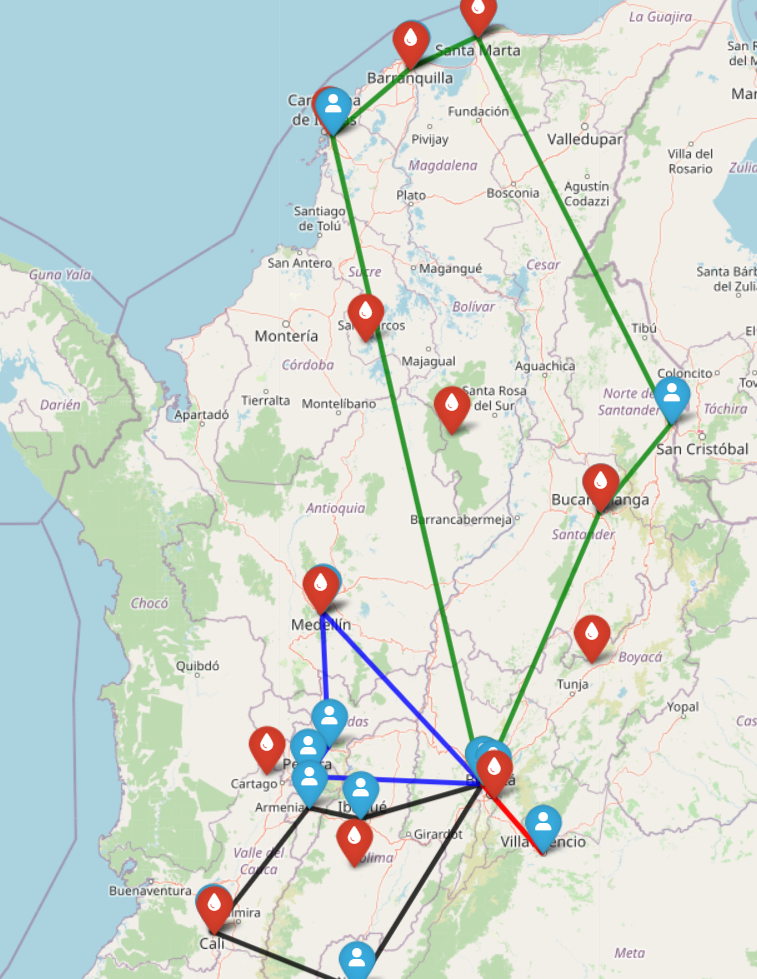